In [2]:
#import
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, metrics)
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from functools import partial
import pandas
import networkx as nx
import numpy as np
import geopandas as gpd
import shapely
from scipy.stats.stats import pearsonr

In [3]:
#load the dual graph
graph = Graph.from_file("./NC_VTD/NC_VTD.shp", ignore_errors=True)
gdf = gpd.read_file("./NC_VTD/NC_VTD.shp")

In [4]:
print("Sample node: ", graph.nodes[0])

Sample node:  {'boundary_node': False, 'area': 1983278.3778237703, 'ALAND10': 1951716.0, 'AWATER10': 32157.0, 'VTD': '3700106W', 'County': '37001', 'VTD_Key': '3700106W', 'VTD_Name': '06W', 'PL10AA_TOT': 1973, 'PL10VA_TOT': 1505, 'EL08G_GV_D': 330, 'EL08G_GV_R': 301, 'EL08G_GV_L': 24, 'EL08G_GV_T': 655, 'EL08G_USS_': 335, 'EL08G_US_1': 288, 'EL08G_US_2': 26, 'EL08G_US_3': 1, 'EL08G_US_4': 650, 'EL10G_USS_': 133, 'EL10G_US_1': 225, 'EL10G_US_2': 12, 'EL10G_US_3': 0, 'EL10G_US_4': 370, 'EL12G_GV_D': 306, 'EL12G_GV_R': 355, 'EL12G_GV_L': 14, 'EL12G_GV_W': 0, 'EL12G_GV_1': 0, 'EL12G_GV_T': 675, 'EL14G_USS_': 181, 'EL14G_US_1': 182, 'EL14G_US_2': 17, 'EL14G_US_3': 1, 'EL14G_US_4': 381, 'Shape_Leng': 7636.330182505912, 'Shape_Area': 1983775.815937991, 'EL12G_PR_D': 351, 'EL12G_PR_R': 324, 'EL12G_PR_L': 10, 'EL12G_PR_W': 0, 'EL12G_PR_1': 1, 'EL12G_PR_T': 686, 'EL16G_PR_R': 271, 'EL16G_PR_D': 339, 'EL16G_PR_L': 11, 'EL16G_PR_W': 12, 'EL16G_PR_T': 633, 'EL16G_USS_': 273, 'EL16G_US_1': 329, 'EL1

In [5]:
#fix some strings which should be numbers
for n in graph.nodes():
    graph.nodes[n]['EL16G_PR_D'] = float(graph.nodes[n]['EL16G_PR_D'])
    graph.nodes[n]['EL16G_PR_R'] = float(graph.nodes[n]['EL16G_PR_R'])


In [6]:
#elections and updaters
dem16_col = "EL16G_PR_D"
rep16_col = "EL16G_PR_R"
pop_col = "TOTPOP"
election_names = [
    "PRES16",
]
election_columns = [
    ["EL16G_PR_D", "EL16G_PR_R"],
]
updaters1 = {
    "population": updaters.Tally(pop_col, alias="population"),
    "cut_edges": cut_edges,
}

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(len(election_names))
]
election_updaters = {election.name: election for election in elections}
updaters1.update(election_updaters)

In [7]:
#real partitions
partition_old = Partition(graph, "oldplan", updaters1)
partition_new = Partition(graph, "newplan", updaters1)
partition_judge = Partition(graph, "judge", updaters1)
partition_list = [
    partition_old, partition_new, partition_judge]
label_list = [
    '2011', '2016', 'judge']
ideal_population = sum(partition_old["population"].values())/len(partition_old)
print("Ideal population: ", ideal_population)

Ideal population:  733498.6923076923


In [41]:
#ReCom run setup
proposal = partial(recom,
                   pop_col=pop_col,
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(partition_old["cut_edges"])
)
pop_constraint = constraints.within_percent_of_ideal_population(partition_old, 0.15)
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=partition_new,
    total_steps=5000
)

In [9]:
#take the subgraph of all nodes with dem vote share > threshold in PRES12
#remove all cut edges from this subgraph
#compute the number of connected components
def ccs_over_districts(part, threshold, subgraph_ccs=None):
    cc_splits = 0
    ccs = 0
    if (subgraph_ccs==None):
        graph = part.graph
        nodes_over_threshold = []
        for i in graph.nodes:
            if float(graph.nodes[i][dem16_col])+float(graph.nodes[i][rep16_col]) != 0:
                if graph.nodes[i][dem16_col]/(
                    graph.nodes[i][dem16_col]+graph.nodes[i][rep16_col]) > threshold:
                    nodes_over_threshold.append(i)
        subgraph = graph.subgraph(nodes_over_threshold)
        connected_components = nx.connected_components(subgraph)
    else:
        connected_components = subgraph_ccs
    for cc in connected_components:
        ccs+=1
        for district in part.assignment.parts:
            if len(cc & part.assignment.parts[district]) != 0:
                cc_splits +=1
    return cc_splits-ccs


In [10]:
def draw_blue_islands(graph, gdf, threshold):
    ass = {x:1 for x in graph.nodes}
    nodes_over_threshold = []
    for i in graph.nodes:
        if float(graph.nodes[i][dem16_col])+float(graph.nodes[i][rep16_col]) != 0:
            if graph.nodes[i][dem16_col]/(
                graph.nodes[i][dem16_col]+graph.nodes[i][rep16_col]) > threshold:
                nodes_over_threshold.append(i)
    subgraph = graph.subgraph(nodes_over_threshold)
    connected_components = nx.connected_components(subgraph)
    for cc in connected_components:
        for node in cc:
            ass[node]=0
    part = GeographicPartition(graph, ass)
    part.plot(gdf, cmap='seismic')

In [11]:
xvals = [x/100 for x in range(0,100)]
subgraph_ccs = {}
for x in xvals:
    nodes_over_threshold = []
    for i in graph.nodes:
        if float(graph.nodes[i][dem16_col])+float(graph.nodes[i][rep16_col]) != 0:
            if graph.nodes[i][dem16_col]/(
                graph.nodes[i][dem16_col]+graph.nodes[i][rep16_col]) > x:
                nodes_over_threshold.append(i)
    subgraph = graph.subgraph(nodes_over_threshold)
    subgraph_ccs_gen = nx.connected_components(subgraph)
    subgraph_ccs[x] = [c for c in subgraph_ccs_gen if sum(
        [graph.nodes[n][pop_col] for n in c]) > 0.05*ideal_population]

Threshold =  0.95 , components =  0


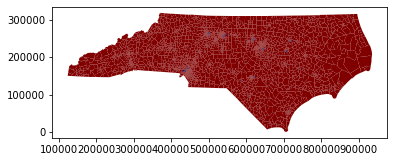

Threshold =  0.9 , components =  5


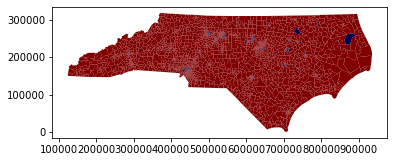

Threshold =  0.85 , components =  6


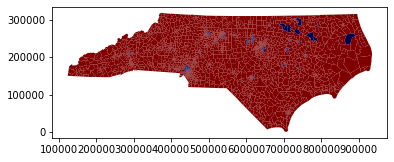

Threshold =  0.8 , components =  5


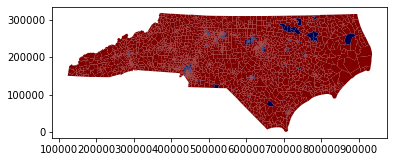

Threshold =  0.75 , components =  7


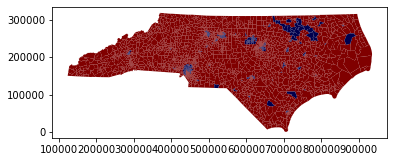

Threshold =  0.7 , components =  9


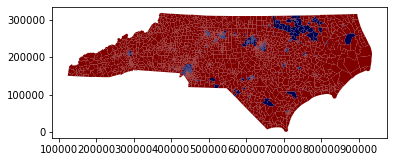

Threshold =  0.65 , components =  9


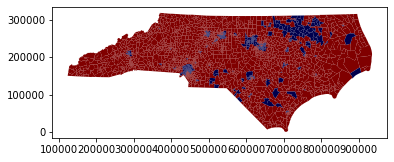

Threshold =  0.6 , components =  9


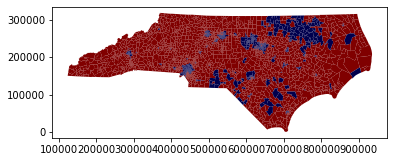

Threshold =  0.55 , components =  11


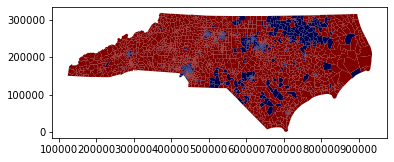

Threshold =  0.5 , components =  13


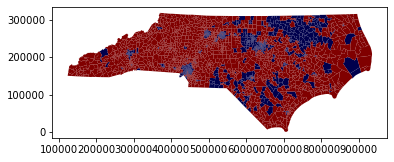

Threshold =  0.45 , components =  12


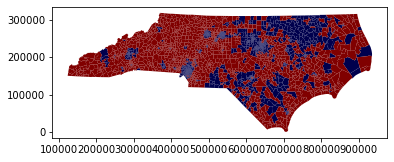

Threshold =  0.4 , components =  12


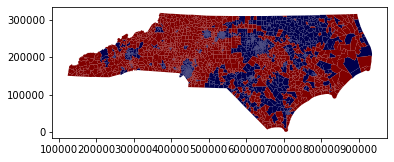

Threshold =  0.35 , components =  9


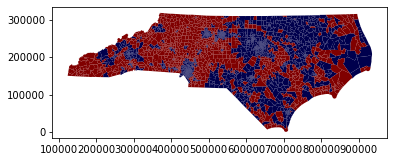

Threshold =  0.3 , components =  8


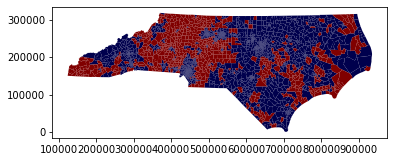

Threshold =  0.25 , components =  5


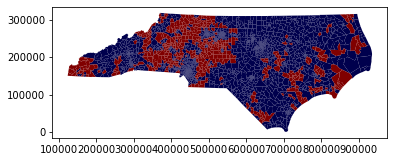

Threshold =  0.2 , components =  2


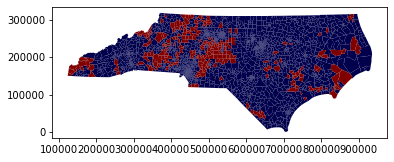

Threshold =  0.15 , components =  1


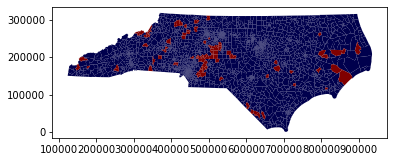

Threshold =  0.1 , components =  1


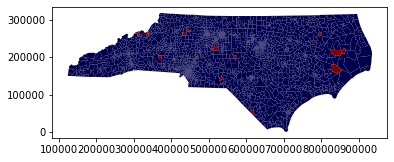

Threshold =  0.05 , components =  1


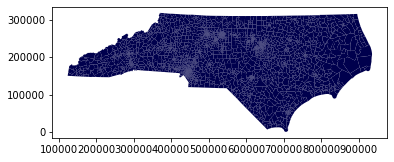

In [39]:
for x in [1-x/20 for x in range(1,20)]:
    print("Threshold = ", round(x,2), ", components = ", len(subgraph_ccs[round(x,2)]))
    draw_blue_islands(graph, gdf, x)
    plt.show()

In [33]:
timer = 0
xvals = [x/100 for x in range(0,100)]
data = {x:[] for x in xvals}
seats = []
for state in chain:
    timer+=1
    if (timer %100 == 0):
        print(timer, end=" ")
    for x in xvals:
        data[x].append(ccs_over_districts(state, x, subgraph_ccs=subgraph_ccs[x]))
    seats.append(state['PRES16'].seats('Democratic'))

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 

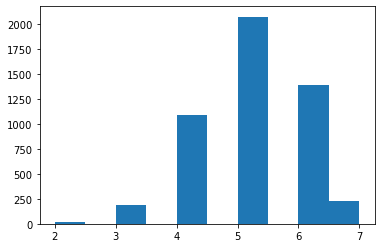

Text(0, 0.5, 'Average districts intersecting connected component')

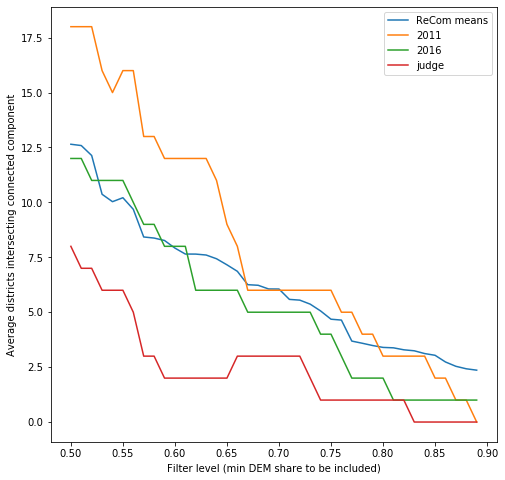

In [50]:
xvals = [x/100 for x in range(50,90)]

plt.hist(seats)
plt.show()

plt.figure(figsize=(8,8))

'''
for i in range(min(seats), max(seats)+1):
    data_means = []
    for x in xvals:
        data_means.append(
            np.mean([data[x][z] for z in range(len(data[x])) if seats[z]==i]))
    plt.plot(xvals, data_means, label="ReCom samples with "+str(i)+" DEM seats.")
'''

data_means = []
for x in xvals:
    data_means.append(
        np.mean([data[x][z] for z in range(len(data[x]))]))
plt.plot(xvals, data_means, label="ReCom means")

for k in range(len(partition_list[0:3])):
    list1 = []
    for i in xvals:
        copy = subgraph_ccs[i]
        list1.append(ccs_over_districts(partition_list[k], i, subgraph_ccs=copy))
    plt.plot(xvals, list1, label=label_list[k])
    plt.legend(loc='lower left')
plt.legend(loc='best')
plt.xlabel("Filter level (min DEM share to be included)")
plt.ylabel("Average districts intersecting connected component")

    

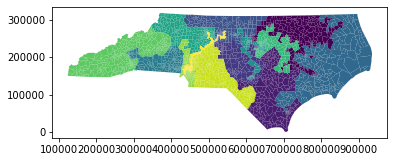

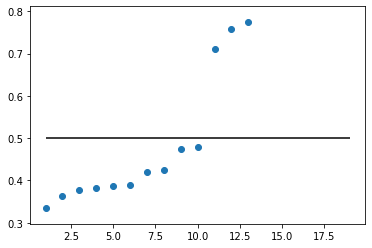

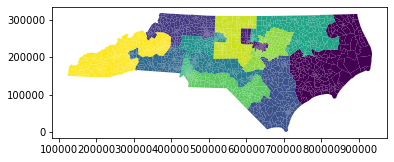

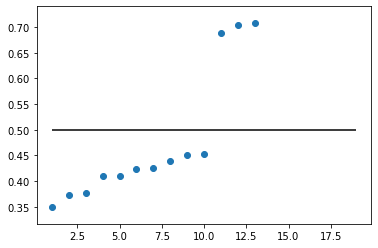

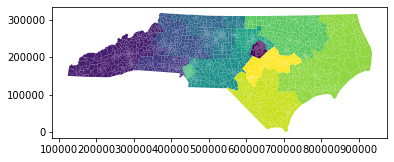

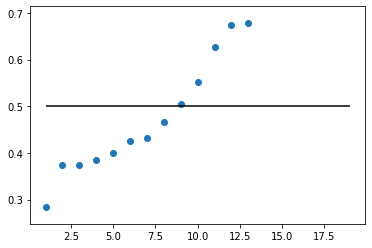

In [43]:
partition_old.plot(gdf)
plt.show()
plt.scatter(range(1,14), sorted(partition_old['PRES16'].percents('Democratic')))
plt.hlines(0.5, 1, 19)
plt.show()
partition_new.plot(gdf)
plt.show()
plt.scatter(range(1,14), sorted(partition_new['PRES16'].percents('Democratic')))
plt.hlines(0.5, 1, 19)
plt.show()
partition_judge.plot(gdf)
plt.show()
plt.scatter(range(1,14), sorted(partition_judge['PRES16'].percents('Democratic')))
plt.hlines(0.5, 1, 19)
plt.show()

### Vector of intersections

In [42]:
#districts intersected by cc
def splits_by_cc(part, cc_list):
    cc_splits = np.zeros(len(cc_list))
    for cc in range(len(cc_list)):
        for d in part.parts:
            if len(cc_list[cc] & part.assignment.parts[d]) != 0:
                cc_splits[cc]+=1
    return cc_splits

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 

(array([  21.,  184., 1093., 2078., 1396.,  228.]),
 array([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 6 Patch objects>)

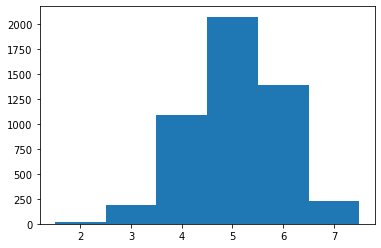

In [43]:
timer = 0
xvals = [x/20 for x in range(2,18)]
data = {x:[] for x in xvals}
seats = []
for state in chain:
    timer+=1
    if (timer %100 == 0):
        print(timer, end=" ")
    for x in xvals:
        data[x].append(splits_by_cc(state, subgraph_ccs[x]))
    seats.append(state['PRES16'].seats('Democratic'))
plt.hist(seats, bins=[x-0.5 for x in range(min(seats), max(seats)+2)])

In [44]:
data_means = {}
data_std = {}
for x in xvals:
    data_means[x] = np.zeros(len(subgraph_ccs[x]))
    for i in range(len(data_means[x])):
        data_means[x][i] = np.mean([z[i] for z in data[x]])
    print(x, " mean vector: ", data_means[x], end = ", ")
    data_std[x] = np.mean(
        [np.linalg.norm(data_means[x]-v) for v in data[x] ]
    )
    print(x, " mean deviation: ", data_std[x])



0.1  mean vector:  [13.], 0.1  mean deviation:  0.0
0.15  mean vector:  [13.], 0.15  mean deviation:  0.0
0.2  mean vector:  [13.      1.3614], 0.2  mean deviation:  0.4826858399999999
0.25  mean vector:  [12.0224  2.6684  1.846   1.8892  1.4558], 0.25  mean deviation:  1.0300330092609067
0.3  mean vector:  [9.4736 1.6998 1.5206 3.7676 1.3608 1.2696 1.394  1.4674], 0.3  mean deviation:  1.511357126219472
0.35  mean vector:  [9.442  1.2322 3.569  1.6604 1.3414 1.3596 1.183  1.4564 1.4508], 0.35  mean deviation:  1.5140100439222592
0.4  mean vector:  [6.0522 4.4496 3.833  1.1874 3.3352 1.5052 1.7328 1.153  1.1162 1.423
 1.34   1.3138], 0.4  mean deviation:  1.9851832080682064
0.45  mean vector:  [4.449  2.367  1.7544 3.2678 2.4058 2.583  1.0922 1.8156 2.8858 1.7126
 1.423  1.2962], 0.45  mean deviation:  2.041206333874813
0.5  mean vector:  [1.219  2.0884 4.1868 1.654  2.3242 2.8258 1.0344 2.6094 1.2954 1.4576
 1.6744 2.2362 1.0418], 0.5  mean deviation:  1.9606548180790524
0.55  mean ve

Text(0, 0.5, 'Distance from ReCom mean')

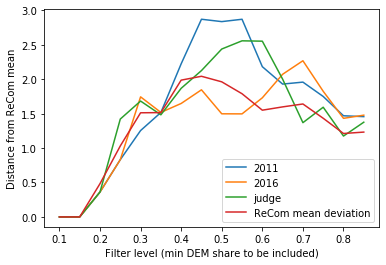

In [45]:
for k in range(len(partition_list[0:3])):
    deviations = []
    for x in xvals:
        deviations.append(np.linalg.norm(
            splits_by_cc(partition_list[k],subgraph_ccs[x])-data_means[x]))
    plt.plot(xvals, deviations, label=label_list[k])
    plt.legend(loc='lower left')
plt.plot(xvals, [data_std[x] for x in xvals], label="ReCom mean deviation")
plt.legend(loc='best')
plt.xlabel("Filter level (min DEM share to be included)")
plt.ylabel("Distance from ReCom mean")

In [46]:
for x in [0.5]:
    print(data_means[x])
    print(splits_by_cc(partition_old,subgraph_ccs[x])-data_means[x])
    print(splits_by_cc(partition_judge,subgraph_ccs[x])-data_means[x])
    print(splits_by_cc(partition_new,subgraph_ccs[x])-data_means[x])

[1.219  2.0884 4.1868 1.654  2.3242 2.8258 1.0344 2.6094 1.2954 1.4576
 1.6744 2.2362 1.0418]
[ 0.781   1.9116  0.8132 -0.654  -0.3242  0.1742  0.9656  0.3906 -0.2954
  0.5424  0.3256 -0.2362  0.9582]
[-0.219   0.9116 -1.1868 -0.654  -0.3242 -0.8258 -0.0344  0.3906 -0.2954
 -0.4576 -0.6744 -1.2362 -0.0418]
[-0.219  -0.0884 -0.1868  0.346  -0.3242  0.1742  0.9656  0.3906 -0.2954
 -0.4576 -0.6744 -0.2362 -0.0418]


Cc with old (2011) plan maximum split deviation:
45


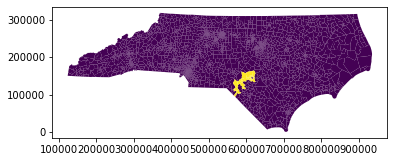

In [40]:
ass = {n:0 for n in graph.nodes()}
x = 0.5
for n in graph.nodes():
    if n in subgraph_ccs[x][1]:
        ass[n] = 1
geog = GeographicPartition(graph, ass, updaters=None)
print("Cc with old (2011) plan maximum split deviation:")
geog.plot(gdf)
print(len(subgraph_ccs[x][1]))

In [36]:
for x in [0.7]:
    print(data_means[x])
    print(splits_by_cc(partition_old,subgraph_ccs[x])-data_means[x])
    print(splits_by_cc(partition_judge,subgraph_ccs[x])-data_means[x])
    print(splits_by_cc(partition_new,subgraph_ccs[x])-data_means[x])

[2.16  1.015 2.097 2.342 1.274 1.616 1.816 1.499 2.18 ]
[-1.16   0.985 -1.097 -0.342 -0.274  0.384  0.184 -0.499  0.82 ]
[-1.16  -0.015 -0.097 -0.342 -0.274 -0.616 -0.816 -0.499 -0.18 ]
[-0.16   0.985 -1.097  0.658 -0.274 -0.616  0.184 -0.499 -1.18 ]


Cc with old (2011) plan big split deviation:


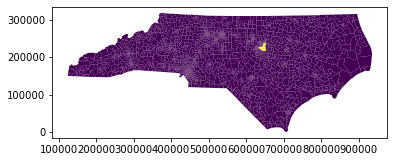

In [34]:
ass = {n:0 for n in graph.nodes()}
x = 0.7
for n in graph.nodes():
    if n in subgraph_ccs[x][2]:
        ass[n] = 1
geog = GeographicPartition(graph, ass, updaters=None)
print("Cc with new (2016) plan big split deviation:")
geog.plot(gdf)

Old (2011) plan:


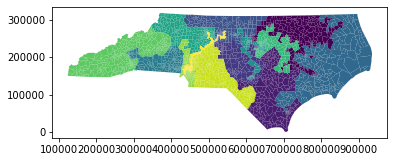

Judge's plan:


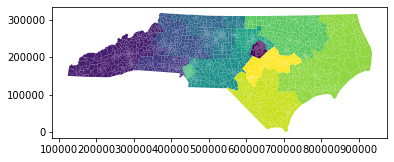

New (2016) plan:


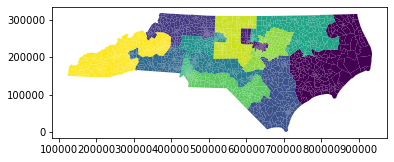

In [38]:
print("Old (2011) plan:")
partition_old.plot(gdf)
plt.show()
print("Judge's plan:")
partition_judge.plot(gdf)
plt.show()
print("New (2016) plan:")
partition_new.plot(gdf)